This file preprocesses the downloaded Statcast 2024 data and prepares input and target tensors for use in the neural network models. To download the 2024 Statcast data, run Download2024Data.ipynb.<br>

Last updated: 4/15/2025

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from torch import save, tensor

In [35]:
#pip freeze > requirements.txt

# Data Preprocessing

## Load data
Load the 2024 Statcast data and pitch clustering data from a CSV. Of course, make sure that you have the full 2024 data csv in your local directory.

In [36]:
pitch_data = pd.read_csv('../2024pitches.csv')
pitch_clusters = pd.read_csv("../pitch_clusters.csv")

In [38]:
target = 'estimated_woba_using_speedangle'
grouping_variables = ['game_date', 'at_bat_number', 'home_team']
features = ['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'spin_axis',
            'release_extension', 'estimated_woba_using_speedangle_zone_avg', 'estimated_woba_by_pitch_type', 
            'cluster_label', 'n_thruorder_pitcher', 'balls', 'strikes']

### Basic Filtering
- Regular season games
- Score difference < 6
- Remove pitches with < 3 appearances

In [39]:
# Regular season games only
pitch_data = pitch_data[pitch_data['game_type'] == 'R']

# Score difference < 6
pitch_data = pitch_data[abs(pitch_data['home_score_diff']) < 6]

# Identify pitchers with < 3 appearances
pitcher_appearances = pitch_data.groupby(['pitcher', 'game_date']).size()
pitcher_games = pitcher_appearances.groupby('pitcher').size()
pitchers_with_few_games = pitcher_games[pitcher_games < 3].index
# Filter out those pitchers
pitch_data = pitch_data[~pitch_data['pitcher'].isin(pitchers_with_few_games)]

### Pitch Clustering

In [40]:
# Grab first set of columns of interest and filter
columns = [
    "pitch_type", "release_speed", "release_pos_x", "release_pos_z", "batter", "pitcher", "events", "description", "zone",
    "des", "game_type", "stand", "p_throws", "type", "balls", "strikes", "pfx_x", "pfx_z", "plate_x", "plate_z", "on_3b",
    "on_2b", "on_1b", "hc_x", "hc_y", "sv_id", "vx0", "vy0", "vz0", "ax", "ay", "az", "sz_top", "sz_bot", "hit_distance_sc",
    "launch_speed", "launch_angle", "effective_speed", "release_spin_rate", "release_extension", "game_pk", "release_pos_y",
    "estimated_woba_using_speedangle", "launch_speed_angle", "at_bat_number", "pitch_number", "pitch_name", "home_score",
    "away_score", "spin_axis", "delta_home_win_exp", "delta_run_exp", "bat_speed", "swing_length",
    "estimated_slg_using_speedangle", "delta_pitcher_run_exp", "bat_win_exp", "n_thruorder_pitcher",
    "n_priorpa_thisgame_player_at_bat", "arm_angle",
    'game_date', 'home_team']
pitch_data = pitch_data[columns]

# Reshape the cluster data to long format and merge with pitch data
pitch_clusters_long = pitch_clusters.melt(id_vars=['pitcher'], var_name='pitch_type', value_name='cluster_label')
pitch_clusters_long = pitch_clusters_long[pitch_clusters_long['cluster_label'] != -1]
pitch_data = pitch_data.merge(pitch_clusters_long, on=['pitcher', 'pitch_type'], how='left')

# Create zone features using the plate_x and plate_z features
x_bins = np.linspace(-2, 2, num=5)  
z_bins = np.linspace(0, 4, num=5)   
pitch_data["zone_x"] = np.digitize(pitch_data["plate_x"], bins=x_bins, right=False)
pitch_data["zone_z"] = np.digitize(pitch_data["plate_z"], bins=z_bins, right=False)
pitch_data["zone"] = pitch_data["zone_x"].astype(str) + "-" + pitch_data["zone_z"].astype(str)

#### K-Nearest Neighbors Implementation

In [41]:
# We want to create hitter zone and pitch type success features using KNN
pitch_data_bip = pitch_data[pitch_data["description"] == "hit_into_play"].copy()
features_knn = ["launch_angle", "launch_speed"]
target_knn = "estimated_woba_using_speedangle"
pitch_data_bip = pitch_data_bip.dropna(subset=features_knn + [target_knn])

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pitch_data_bip[features_knn])

# Train KNN to estimate hitter performance based on launch angle and exit velocity
knn = KNeighborsRegressor(n_neighbors=10, weights="distance")
knn.fit(X_scaled, pitch_data_bip[target_knn])

pitch_data_bip["xwOBA_KNN"] = knn.predict(X_scaled)  #apply predictions back to the dataset

# Calculate average predicted expected wOBA per zone and pitch type for hitters
zone_success = pitch_data_bip.groupby(["batter", "zone_x", "zone_z"])["xwOBA_KNN"].mean().reset_index()
pitch_type_success = pitch_data_bip.groupby(["batter", "pitch_type"])[target_knn].mean().reset_index()
pitch_type_success.rename(columns={target_knn: "estimated_woba_by_pitch_type"}, inplace=True)
pitcher_zone_xwoba = pitch_data_bip.groupby(["pitcher", "zone_x", "zone_z"])[target_knn].mean().reset_index()
pitcher_zone_xwoba.rename(columns={target_knn: "pitcher_zone_xwoba_allowed"}, inplace=True)

pitch_data = pitch_data.drop(columns=["estimated_woba_using_speedangle_zone_avg"], errors="ignore")
# Merge new metrics back into dataset
pitch_data = pitch_data.merge(zone_success, on=["batter", "zone_x", "zone_z"], how="left")
pitch_data = pitch_data.merge(pitch_type_success, on=["batter", "pitch_type"], how="left")
pitch_data = pitch_data.merge(pitcher_zone_xwoba, on=["pitcher", "zone_x", "zone_z"], how="left")
pitch_data.rename(columns={"xwOBA_KNN": "estimated_woba_using_speedangle_zone_avg"}, inplace=True)

print("Number of pitches:", pitch_data.shape[0])

Number of pitches: 641358


### Grouping

Grouping data into unique at-bats. Group pitches into a dataframe of unique at-bats. Grouped by gate date, at bat number, and home team. First row in each pitch frame is the last pitch in the sequence.

Removing rows and at-bats where pitch_type, release_speed, spin_axis, release_extension, and effective_speed have NA values. I made sure to remove entire at-bat sequences.

In [44]:
# Filter down to just the relevant columns (features + target)
cols = ['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'spin_axis',
            'release_extension', 'estimated_woba_using_speedangle_zone_avg', 'estimated_woba_by_pitch_type', 
            'launch_angle', 'launch_speed',
            'cluster_label', 'n_thruorder_pitcher', 'balls', 'strikes',
            'game_date', 'at_bat_number', 'home_team',
            'description',
            target]

pitch_data_filtered = pitch_data[cols]
print("Number of pitches:", pitch_data_filtered.shape[0])

Number of pitches: 641358


In [45]:
# Group by the specified columns
grouped = pitch_data_filtered.groupby(grouping_variables)
# First row in each pitch frame is the last pitch in the sequence - note that there's a value for wOBA
print("Number of pitch sequences:", len(grouped))
grouped.first()

Number of pitch sequences: 163020


release_speed  release_pos_x  \
game_date  at_bat_number home_team                                 
2024-03-20 1             SD                  93.9          -2.17   
           2             SD                  91.1          -2.05   
           3             SD                  95.4          -2.11   
           4             SD                  94.5          -1.91   
           5             SD                  96.9          -1.74   
...                                           ...            ...   
2024-09-30 78            ATL                 86.2          -2.08   
           79            ATL                 94.2          -2.16   
           80            ATL                 90.4          -2.16   
           81            ATL                 91.0          -2.00   
           82            ATL                 97.4          -2.10   

                                    release_pos_z  pfx_x  pfx_z  plate_x  \
game_date  at_bat_number home_team                                         
2024-03-20 1             SD                  5.70  -1.34   1.09    -2.02   
           2             SD                  5.58  -1.33   0.22    -0.80   
           3             SD                  5.61  -1.51   0.56     0.33   
           4             SD                  5.67  -0.35   1.62    -0.07   
           5             SD                  6.05  -0.03   1.56    -0.28   
...                                           ...    ...    ...      ...   
2024-09-30 78            ATL                 5.95   0.58  -0.51     0.54   
           79            ATL                 4.93  -1.11   1.20     0.84   
           80            ATL                 5.12   0.18   0.47     0.53   
           81            ATL                 5.21   0.26   0.62     1.25   
           82            ATL                 4.88  -0.96   0.99     0.67   

                                    plate_z  spin_axis  release_extension  \
game_date  at_bat_number home_team                                          
2024-03-20 1             SD            2.90      233.0                5.9   
           2             SD            2.82      264.0                5.8   
           3             SD            2.22      253.0                6.0   
           4             SD            2.37      193.0                6.2   
           5             SD            2.66      181.0                8.0   
...                                     ...        ...                ...   
2024-09-30 78            ATL           0.75       45.0                5.9   
           79            ATL           2.93      233.0                7.5   
           80            ATL           1.73      215.0                7.2   
           81            ATL           2.22      204.0                7.4   
           82            ATL           3.00      232.0                7.6   

                                    estimated_woba_using_speedangle_zone_avg  \
game_date  at_bat_number home_team                                             
2024-03-20 1             SD                                         0.389278   
           2             SD                                         0.628048   
           3             SD                                         0.404005   
           4             SD                                         0.354902   
           5             SD                                         0.390271   
...                                                                      ...   
2024-09-30 78            ATL                                        0.102750   
           79            ATL                                        0.443276   
           80            ATL                                        0.613500   
           81            ATL                                        0.298333   
           82            ATL                                        0.251674   

                                    estimated_woba_by_pitch_type  \
game_date  at_bat_number home_team                 

Remove groups that don't have any rows with a value for estimated woba using speedangle or a value of 'hit_into_play' for 'description'. Basically, if there's any at-bats where a ball was not hit into play.

In [46]:
# Removing groups where none of the rows have a estimated woba using speedangle
filtered_grouped = grouped.filter(lambda group: group[target].notna().any())
grouped = filtered_grouped.groupby(grouping_variables)
print("Number of pitch sequences:", len(grouped))

# Removing groups where none of the rows have 'hit_into_play' in 'description' column
filtered_grouped = grouped.filter(lambda group: (group['description'] == 'hit_into_play').any())
grouped = filtered_grouped.groupby(grouping_variables)
print("Number of pitch sequences:", len(grouped))

Number of pitch sequences: 161534
Number of pitch sequences: 110320


Notice that all of the below (last pitch in sequence) now have a description of 'hit_into_play'.

In [47]:
grouped.first()['description']

game_date   at_bat_number  home_team
2024-03-20  2              SD           hit_into_play
            4              SD           hit_into_play
            5              SD           hit_into_play
            6              SD           hit_into_play
            8              SD           hit_into_play
                                            ...      
2024-09-30  76             ATL          hit_into_play
            77             ATL          hit_into_play
            79             ATL          hit_into_play
            80             ATL          hit_into_play
            82             ATL          hit_into_play
Name: description, Length: 110320, dtype: object

### Sequence Clipping and Padding

I want to make mimize one or two very long sequences causing us to increase the size of our time series dataframe dramatically. So, will clip the top 1% of length outliers (which at time of writing means clipping any time series with more than 8 pitches).

Get feature array into a homogenous shape. That is, pad sequences to the max sequence length so that they all have the same number of rows. Pad with 0.0 to the end of the sequence.

In [48]:
def drop_long_sequences(df):
    # Get number of pitches each at-bat has
    sizes = df.size().values
    # Determine number to drop (0.99% of data)
    max_pitches = np.quantile(sizes, 0.99)
    print(f"Max sequence length is {sizes.max()}. Include sequences with less than {int(max_pitches) + 1} pitches.")
    # Drop groups with these
    filtered_df = df.filter(lambda x: len(x) <= max_pitches)
    filtered_group = filtered_df.groupby(['game_date', 'at_bat_number', 'home_team'])

    return filtered_group


def grouped_to_array_pad(grouped_df):
    # Get grouped features into one array, ensure each sequence has exactly 9 rows in one loop
    output_array = []

    # Max number of rows in a sequence
    max_seq = grouped_df.size().values.max()

    # Number of variables used
    n_vars = grouped_df.first().columns.shape[0]

    for group in grouped_df:
        # Convert sequence to numpy array
        seq = group[1].to_numpy(dtype='float32')
        # Pad end of sequences to get homogenous shape
        if len(seq) < max_seq:
            padding = np.full((max_seq - len(seq), n_vars), 0.0, dtype='float32')
            seq = np.concatenate([seq, padding])
        elif len(seq) > max_seq:
            break
        # Append sequence to output values
        output_array.append(seq)
    # Convert to numpy array
    output_array = np.array(output_array, dtype='float32')

    return output_array

In [49]:
# Drop any exceptionally long sequences
grouped = drop_long_sequences(grouped)

# Filter variables down
grouped_features = grouped[features]

# Get features into one array of equal size
input_values = grouped_to_array_pad(grouped_features)
print("Number of unique pitch sequences: ", len(grouped))

Max sequence length is 18. Include sequences with less than 10 pitches.
Number of unique pitch sequences:  109601


In [50]:
grouped_features.first().columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'plate_x', 'plate_z', 'spin_axis', 'release_extension',
       'estimated_woba_using_speedangle_zone_avg',
       'estimated_woba_by_pitch_type', 'cluster_label', 'n_thruorder_pitcher',
       'balls', 'strikes'],
      dtype='object')

### Finalize predictors and targets

In [51]:
# Get last pitches in sequence (first in series) and convert to numpy array. These contain the wOBA values
ys = grouped.first()[target].to_numpy(dtype='float32')

In [52]:
# Confirm that targets and features have the same number of rows
print("Number of pitch sequences (features):", ys.shape[0])
print("Number of pitch sequences (targets):", input_values.shape[0])
assert input_values.shape[0] == ys.shape[0]
print("Number of variables:", input_values[0].shape[1])

Number of pitch sequences (features): 109601
Number of pitch sequences (targets): 109601
Number of variables: 15


In [53]:
# One last time, drop nan values (sequences with nan values)
nan_seqs = np.where([np.isnan(row).sum() > 0 for row in input_values])
ys_final = np.delete(ys, nan_seqs, axis=0)
input_values_final = np.delete(input_values, nan_seqs, axis=0)

In [54]:
print("Number of pitch sequences:", ys_final.shape[0])
print("Number of variables:", input_values_final[0].shape[1])

Number of pitch sequences: 71958
Number of variables: 15


### Target value distribution

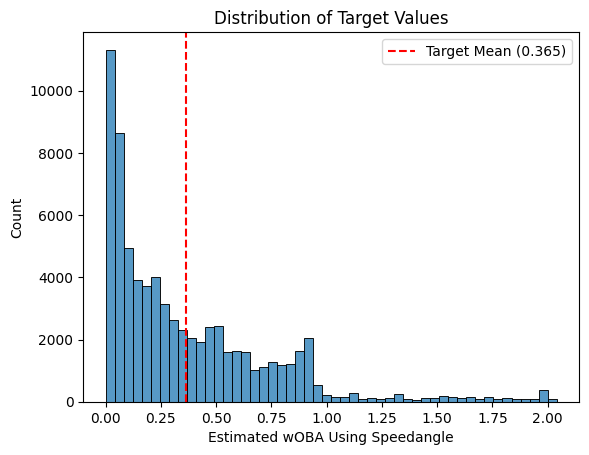

In [55]:
plt.title("Distribution of Target Values")
sns.histplot(ys_final, bins=50)
plt.axvline(x=ys_final.mean(), color='r', linestyle='--', label=f'Target Mean ({ys_final.mean():.3f})')
plt.legend()
plt.xlabel("Estimated wOBA Using Speedangle")
plt.show()

In [56]:
# Print descriptive statistics
print(f"Mean: {np.mean(ys_final)}")
print(f"Median: {np.median(ys_final)}")
print(f"Standard Deviation: {np.std(ys_final)}")
print(f"Variance: {np.var(ys_final)}")
print(f"Minimum: {np.min(ys_final)}")
print(f"Maximum: {np.max(ys_final)}")

Mean: 0.36450380086898804
Median: 0.23899999260902405
Standard Deviation: 0.3813591003417969
Variance: 0.14543475210666656
Minimum: 0.0
Maximum: 2.0409998893737793


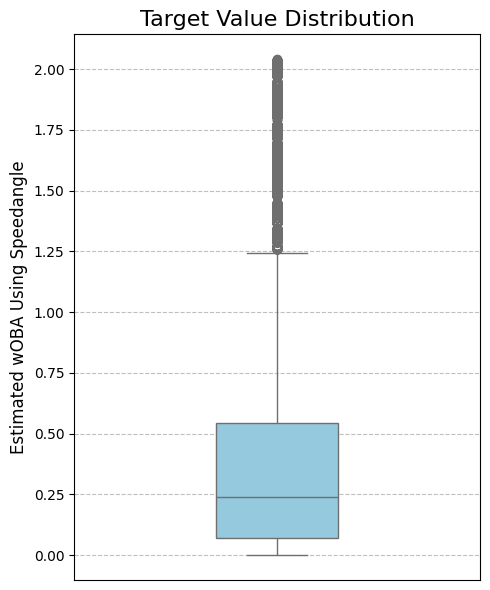

In [57]:
plt.figure(figsize=(5, 6))
sns.boxplot(y=ys_final, color='skyblue', width=0.3)
plt.title('Target Value Distribution', fontsize=16)
plt.ylabel('Estimated wOBA Using Speedangle', fontsize=12)
plt.xticks([])
plt.grid(True, linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

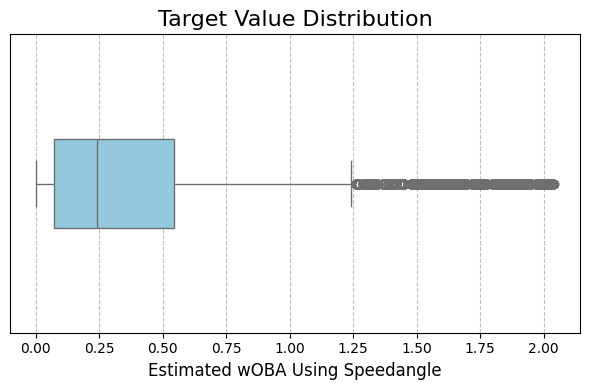

In [58]:
plt.figure(figsize=(6, 4))  # Wider than tall now
sns.boxplot(x=ys_final, color='skyblue', width=0.3)
plt.title('Target Value Distribution', fontsize=16)
plt.xlabel('Estimated wOBA Using Speedangle', fontsize=12)
plt.yticks([])
plt.grid(True, linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

### Save input and target tensors for disk for future use

Example usage:<br>
MLP_dataset = TensorDataset(input_tensor, target_vals)


In [59]:
# Check one last time that target and input has same length. Print input size
print(f"Input shape: {input_values_final.shape}")
assert input_values_final.shape[0] == ys_final.shape[0]
print(f"Count of nans: {np.isnan(input_values_final).sum()}, {np.isnan(ys_final).sum()}")

# Convert the list of numpy arrays to a list of tensors
input_tensor = tensor(np.array([tensor(series) for series in input_values_final]))
target_vals = tensor(ys_final)

# Save input and target tensors with torch.save
save(input_tensor, './datasets/input_values.pth')
save(target_vals, './datasets/target_values.pth')

Input shape: (71958, 9, 15)
Count of nans: 0, 0


In [60]:
'''inds = np.where(ys_final > 1.0)[0]
#weights = np.where(ys_final[inds] < 0.25, 2, 1)  # Give weight of 10 to values under 0.1, and 1 otherwise
#weights = weights / weights.sum()
balance_mask = np.random.choice(inds, int(len(inds) * 1), replace=False)# p=weights)

new_ys = tensor(np.delete(target_vals.numpy(), balance_mask))
new_inputs = tensor(np.delete(input_tensor.numpy(), balance_mask, axis=0))

print(new_ys.shape, new_inputs.shape)


inds = np.where(new_ys.numpy() < 0.1)[0]
#weights = np.where(ys_final[inds] < 0.25, 2, 1)  # Give weight of 10 to values under 0.1, and 1 otherwise
#weights = weights / weights.sum()
balance_mask = np.random.choice(inds, int(len(inds) * 0.5), replace=False)# p=weights)

new_ys = tensor(np.delete(new_ys.numpy(), balance_mask))
new_inputs = tensor(np.delete(new_inputs.numpy(), balance_mask, axis=0))


# Find indices where the values are below 0.1
indices_to_delete = np.where(ys_final <= 0.25)[0]
# Filter out values below 0.1
new_ys = ys_final[target_vals.numpy() > 0.25]
new_inputs = np.delete(input_tensor.numpy(), indices_to_delete, axis=0)

print(new_ys.shape, new_inputs.shape)


plt.title("Distribution of Target Values")
sns.histplot(new_ys, bins=100)
plt.axvline(x=new_ys.mean(), color='r', linestyle='--', label=f'Target Mean ({new_ys.mean():.3f})')
plt.legend()
plt.xlabel("Estimated Woba Using Speedangle")
plt.show()


# Save input and target tensors with torch.save
save(new_inputs, './datasets/input_values.pth')
save(new_ys, './datasets/target_values.pth')
np.median(new_ys)'''

'inds = np.where(ys_final > 1.0)[0]\n#weights = np.where(ys_final[inds] < 0.25, 2, 1)  # Give weight of 10 to values under 0.1, and 1 otherwise\n#weights = weights / weights.sum()\nbalance_mask = np.random.choice(inds, int(len(inds) * 1), replace=False)# p=weights)\n\nnew_ys = tensor(np.delete(target_vals.numpy(), balance_mask))\nnew_inputs = tensor(np.delete(input_tensor.numpy(), balance_mask, axis=0))\n\nprint(new_ys.shape, new_inputs.shape)\n\n\ninds = np.where(new_ys.numpy() < 0.1)[0]\n#weights = np.where(ys_final[inds] < 0.25, 2, 1)  # Give weight of 10 to values under 0.1, and 1 otherwise\n#weights = weights / weights.sum()\nbalance_mask = np.random.choice(inds, int(len(inds) * 0.5), replace=False)# p=weights)\n\nnew_ys = tensor(np.delete(new_ys.numpy(), balance_mask))\nnew_inputs = tensor(np.delete(new_inputs.numpy(), balance_mask, axis=0))\n\n\n# Find indices where the values are below 0.1\nindices_to_delete = np.where(ys_final <= 0.25)[0]\n# Filter out values below 0.1\nnew_ys